In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anuhyatyada","key":"a6468d3e234d4892ddcfe865f584cadf"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers accelerate
!pip install kaggle --quiet

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lwx5jwit
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lwx5jwit
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
from ultralytics import YOLO
import clip
import torch
from PIL import Image
import torchvision.transforms as T
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from transformers import T5ForConditionalGeneration, T5Tokenizer
import matplotlib.pyplot as plt
import torch
import matplotlib.image as mpimg
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import Image, display
import re

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hiteshsuthar101/myntra-fashion-product-dataset

Dataset URL: https://www.kaggle.com/datasets/hiteshsuthar101/myntra-fashion-product-dataset
License(s): ODC Public Domain Dedication and Licence (PDDL)


In [ ]:
# Load the model
model = YOLO('/content/drive/MyDrive/upload_files/best.pt')


In [ ]:
results = model.predict(source='/content/drive/MyDrive/upload_files/test4.jpeg', conf=0.4, save=True)



image 1/1 /content/drive/MyDrive/upload_files/test4.jpeg: 512x288 1 jacket, 1 pants, 1 shoe, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 288)
Results saved to runs/detect/predict2


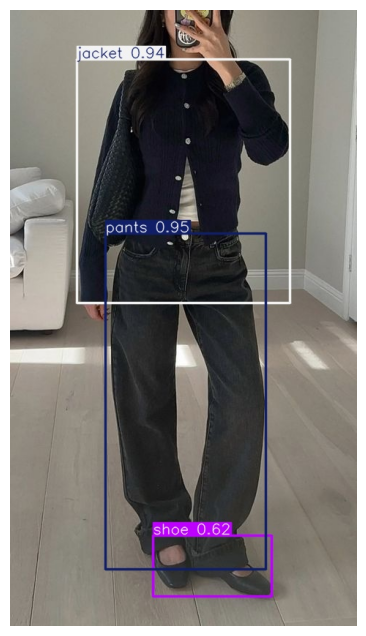

In [ ]:


# Path to the saved prediction
pred_img_path = '/content/runs/detect/predict/test4.jpg'

# Show the image
img = mpimg.imread(pred_img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
results = model.predict('/content/runs/detect/predict/test4.jpg')
boxes = results[0].boxes


image 1/1 /content/runs/detect/predict/test4.jpg: 512x288 1 jacket, 1 pants, 1 shoe, 20.8ms
Speed: 1.6ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 288)


In [ ]:
orig_img = results[0].orig_img

In [ ]:
cropped_items = []
for i, box in enumerate(boxes.xyxy):
    x1, y1, x2, y2 = map(int, box)
    cropped = orig_img[y1:y2, x1:x2]
    cropped_items.append(cropped)


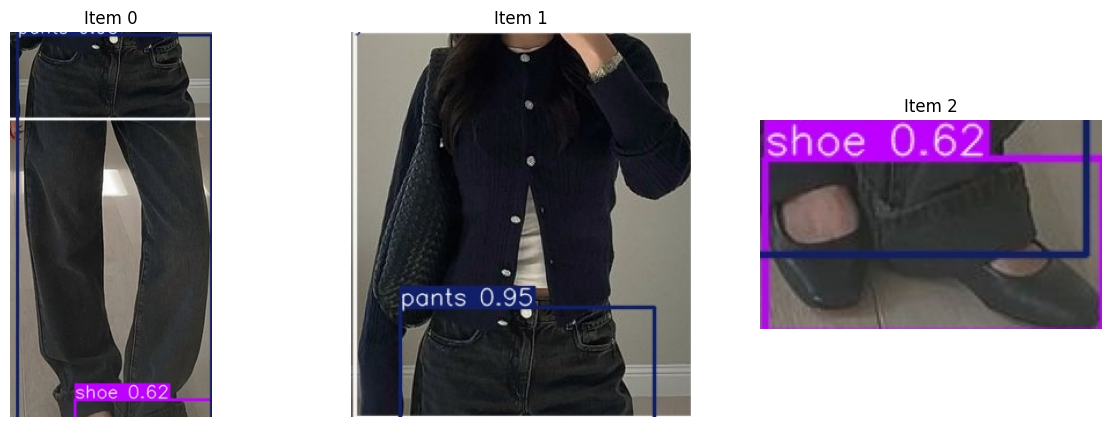

In [ ]:
import cv2

plt.figure(figsize=(15, 5))

for idx, crop in enumerate(cropped_items):
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(cropped_items), idx + 1)
    plt.imshow(crop_rgb)
    plt.axis('off')
    plt.title(f'Item {idx}')

plt.show()


In [ ]:
selected_idx = int(input("Enter the item number you want to style: "))

selected_crop = cropped_items[selected_idx]

Enter the item number you want to style: 0


In [ ]:
# Load CLIP model
model_clip, preprocess = clip.load("ViT-B/32", device="cpu")

# Convert numpy array (OpenCV image) to PIL image
selected_pil = Image.fromarray(cv2.cvtColor(selected_crop, cv2.COLOR_BGR2RGB))

# Preprocess and send through CLIP
image = preprocess(selected_pil).unsqueeze(0).to('cpu')

# Get the CLIP embedding
with torch.no_grad():
    image_features = model_clip.encode_image(image)

In [ ]:
fashion_items = ['sunglass', 'hat', 'jacket', 'shirt', 'pants', 'shorts', 'skirt', 'dress', 'bag', 'shoe']
colors = ['red', 'blue', 'green', 'black', 'white', 'yellow', 'pink', 'purple', 'brown', 'gray']
textures = {
    'sunglass': ['plastic', 'metal', 'acetate'],  # Suitable materials for sunglasses
    'hat': ['cotton', 'wool', 'felt', 'linen', 'canvas'],
    'jacket': ['leather', 'denim', 'suede', 'wool', 'nylon'],
    'shirt': ['cotton', 'linen', 'silk', 'nylon', 'flannel'],
    'pants': ['denim', 'cotton', 'linen', 'wool', 'nylon'],
    'shorts': ['cotton', 'denim', 'linen', 'nylon', 'wool'],
    'skirt': ['cotton', 'denim', 'silk', 'wool', 'nylon'],
    'dress': ['silk', 'cotton', 'linen', 'velvet', 'wool'],
    'bag': ['leather', 'canvas', 'nylon', 'suede', 'cotton'],
    'shoe': ['leather', 'suede', 'canvas', 'nylon', 'rubber']
}

text_descriptions = []

for item in fashion_items:
    for color in colors:
        for texture in textures.get(item, textures['hat']):  # Default texture to 'hat' if no specific one is set
            description = f"a {color} {texture} {item}"
            text_descriptions.append(description)

In [ ]:
text_features = np.load('/content/drive/MyDrive/upload_files/text_features.npy')

In [ ]:
similarities = cosine_similarity(image_features, text_features)

In [ ]:
best_matches = similarities.argmax(axis=1)

# Get descriptions
matched_descriptions = [text_descriptions[idx] for idx in best_matches]

# Print results
for i, desc in enumerate(matched_descriptions):
    result_str = ""
    result_str += f"{desc}\n"

print(result_str)


a blue linen pants



In [ ]:
items = [line.strip() for line in result_str.strip().split('\n') if line.strip()]

prompts = [f"how to style {item}" for item in items]

print(prompts)


['how to style a blue linen pants']


In [ ]:
class Config:
    MAX_INPUT_LENGTH = 512
    MAX_TARGET_LENGTH = 512

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("/content/drive/MyDrive/upload_files/fashion_chatbot_model")
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/upload_files/fashion_chatbot_model")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
def test_model(model, tokenizer, test_questions, config):
    """Test the trained model with some fashion advice questions"""
    model.eval()

    results = []
    for question in test_questions:
        inputs = tokenizer(
            question,
            return_tensors="pt",
            max_length=config.MAX_INPUT_LENGTH,
            padding="max_length",
            truncation=True
        )

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Generate output
        output_ids = model.generate(
            **inputs,
            max_length=config.MAX_TARGET_LENGTH,
            num_beams=4,
            early_stopping=True
        )

        # Decode the output
        output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        results.append({"question": question, "answer": output})

    return pd.DataFrame(results)

In [ ]:
results_df = test_model(model, tokenizer, prompts, Config)
print(results_df)

                          question                                  answer
0  how to style a blue linen pants  Wear them with a t-shirt and a blazer.


In [ ]:
answers = results_df["answer"].tolist()
print(answers)



['Wear them with a t-shirt and a blazer.']


In [ ]:
all_attributes = []
for ans in answers:
    # Find phrases after prepositions/articles until the next preposition/article/punctuation
    matches = re.findall(r'\b(?:with|and|a|an|the)\s+([^,.;:!?]*?)(?=\s+\b(?:with|and|a|an|the|for)\b|[,.;:!?]|$)',
                         ans, flags=re.IGNORECASE)

    # Clean up the matches
    cleaned_matches = [match.strip() for match in matches if match.strip()]
    all_attributes.extend(cleaned_matches)

print(all_attributes)

['a t-shirt', 'a blazer']


In [ ]:
!unzip -q myntra-fashion-product-dataset.zip

In [ ]:
df = pd.read_csv('/content/FashionDataset.csv')

print(df.columns)


df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['name', 'description'])

df = df[df['img'].notna() & df['img'].str.startswith('http://assets.myntassets.com')]

df['text'] = df['name'].astype(str) + " " + df['description'].astype(str) + " " + df['p_attributes'].astype(str)

Index(['Unnamed: 0', 'p_id', 'name', 'price', 'colour', 'brand', 'img',
       'ratingCount', 'avg_rating', 'description', 'p_attributes'],
      dtype='object')


In [ ]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit and transform the 'text' column
tfidf_matrix = vectorizer.fit_transform(df['text'])


In [ ]:
def find_similar_products(query, top_n=5):
    query_vec = vectorizer.transform([query])  # Vectorize the input query
    similarity_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()  # Get similarity scores
    top_indices = similarity_scores.argsort()[-top_n:][::-1]  # Get top N most similar items

    # Return top results
    return df.iloc[top_indices][['p_id', 'name', 'brand', 'price', 'img']]

# Step 9: Function to display images of the results
def show_images(result_df):
    for _, row in result_df.iterrows():
        print(f"{row['name']} ({row['brand']}) - ₹{row['price']}")
        img_url = row.get('img', None)
        if pd.notna(img_url):
            try:
                display(Image(url=img_url))  # Display image
            except Exception as e:
                print("Image could not be displayed:", e)
        else:
            print("No image available for this item.")


In [ ]:
similar_results = {item: find_similar_products(item, top_n=10) for item in all_attributes}

for item, products in similar_results.items():
    print(f"{item} → {products}")


a t-shirt →             p_id                                               name  \
7255  16012788.0  JC Collection Women Blue & White Shirt with Skirt   
7285  16542196.0   Cottinfab Women Grey Solid T-shirt with Trousers   
6782  16542192.0     Cottinfab Women Solid Rust Shirt with Trousers   
6814  18529894.0  JC Collection Women Black & White Printed Shir...   
7371  17348906.0  JC Collection Women Red & White Printed Shirt ...   
6896  18529956.0  JC Collection Women Pink & White Printed Shirt...   
6905  17348862.0  JC Collection Women Pink & Green Printed Shirt...   
7003  18529856.0  JC Collection White Floral Print Shirt & Short...   
6856  17348940.0  JC Collection Women White & Blue Printed Shirt...   
6904  18529986.0  JC Collection Women Black & Purple Shirt with ...   

              brand   price                                                img  
7255  JC Collection  6799.0  http://assets.myntassets.com/assets/images/160...  
7285      Cottinfab  3199.0  http://assets.m

In [ ]:
for item, result_df in similar_results.items():
    print(f"\n🔍 Similar products for: {item}")
    show_images(result_df)



🔍 Similar products for: a t-shirt
JC Collection Women Blue & White Shirt with Skirt (JC Collection) - ₹6799.0


Cottinfab Women Grey Solid T-shirt with Trousers (Cottinfab) - ₹3199.0


Cottinfab Women Solid Rust Shirt with Trousers (Cottinfab) - ₹3299.0


JC Collection Women Black & White Printed Shirt with Trousers (JC Collection) - ₹5999.0


JC Collection Women Red & White Printed Shirt with Skirt Co-Ords Set (JC Collection) - ₹5699.0


JC Collection Women Pink & White Printed Shirt & Skirt Co-Ords (JC Collection) - ₹6099.0


JC Collection Women Pink & Green Printed Shirt with Trousers (JC Collection) - ₹5999.0


JC Collection White Floral Print Shirt & Shorts Co-ords (JC Collection) - ₹5699.0


JC Collection Women White & Blue Printed Shirt with Trousers (JC Collection) - ₹5899.0


JC Collection Women Black & Purple Shirt with Skirt (JC Collection) - ₹5999.0



🔍 Similar products for: a blazer
DEEBACO Women Magenta Cotton Blazer with Trousers (DEEBACO) - ₹3199.0


Athena Women Mustard Yellow Solid Blazer with Trousers (Athena) - ₹2999.0


SASSAFRAS Grey Blazer (SASSAFRAS) - ₹1799.0


URBANIC Rust Red Solid Co-ord Set (URBANIC) - ₹2290.0


Golden Kite Women Pink Solid Blazer & Trouser (Golden Kite) - ₹3999.0


Allen Solly Woman Navy Blue Solid Blazer (Allen Solly Woman) - ₹3299.0


RAISIN Women Gold-Toned Brocade Blazer with Trousers (RAISIN) - ₹6499.0


URBANIC Women Beige & White Solid Open-Front With Tie-Up Closure Casual Blazer (URBANIC) - ₹1690.0


URBANIC Women Grey Solid Drop-Shoulder Sleeves Front-Open Blazer (URBANIC) - ₹2090.0


Shae by SASSAFRAS Women Red Short Sleeve Fabric-Belt Blazer (Shae by SASSAFRAS) - ₹1799.0


In [ ]:
# Virtual Try-On with Pixelcut API - Direct File Upload Version
import requests
import io
import os
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Function to upload images from local computer
def upload_images():
  print("Please upload a person/model image:")
  person_file = files.upload()
  person_filename = list(person_file.keys())[0]

  print("\nPlease upload a garment/clothing image:")
  garment_file = files.upload()
  garment_filename = list(garment_file.keys())[0]

  return person_filename, garment_filename

# Function to display images side by side
def display_images(person_img_path, garment_img_path, result_img_path=None):
  fig = plt.figure(figsize=(15, 5))

  # Display person image
  ax1 = fig.add_subplot(1, 3 if result_img_path else 2, 1)
  img1 = Image.open(person_img_path)
  ax1.imshow(img1)
  ax1.set_title('Person/Model Image')
  ax1.axis('off')

  # Display garment image
  ax2 = fig.add_subplot(1, 3 if result_img_path else 2, 2)
  img2 = Image.open(garment_img_path)
  ax2.imshow(img2)
  ax2.set_title('Garment Image')
  ax2.axis('off')

  # Display result image if available
  if result_img_path:
    ax3 = fig.add_subplot(1, 3, 3)
    img3 = Image.open(result_img_path)
    ax3.imshow(img3)
    ax3.set_title('Try-On Result')
    ax3.axis('off')

  plt.tight_layout()
  plt.show()

# Function to call Pixelcut Try-On API with direct file upload
def try_on_clothing_with_files(person_image_path, garment_image_path, api_key):
  url = "https://api.developer.pixelcut.ai/v1/try-on"

  files = {
    'person_image': open(person_image_path, 'rb'),
    'garment_image': open(garment_image_path, 'rb')
  }

  headers = {
    'Accept': 'application/json',
    'X-API-KEY': api_key
  }

  print("Sending request to Pixelcut Try-On API with direct file upload...")
  response = requests.post(url, headers=headers, files=files)

  if response.status_code == 200:
    result = response.json()
    result_url = result.get("result_url")
    print(f"Success! Result image available at: {result_url}")
    return result_url
  else:
    print(f"Error: {response.status_code}")
    print(response.text)
    return None

# Function to download image from URL
def download_image(url, save_path):
  response = requests.get(url)
  if response.status_code == 200:
    with open(save_path, 'wb') as f:
      f.write(response.content)
    print(f"Image downloaded and saved to {save_path}")
    return save_path
  else:
    print(f"Failed to download image from {url}")
    return None

# Main execution flow
def main():
  # Display welcome message and instructions
  display(HTML("""
  <h1>Virtual Try-On with Pixelcut API - Direct File Upload</h1>
  <p>This notebook allows you to visualize how clothing items would look on a model using Pixelcut's Try-On API.</p>
  <p><b>Instructions:</b></p>
  <ol>
    <li>Enter your Pixelcut API key when prompted</li>
    <li>Upload a person/model image</li>
    <li>Upload a garment/clothing image</li>
    <li>Wait for the API to process and display the result</li>
  </ol>
  <p><b>Note:</b> For best results:</p>
  <ul>
    <li>Person image should have only one person, preferably with a plain background</li>
    <li>The person should be standing facing forward in a 3/4 body view</li>
    <li>Garment image should contain a single garment that takes up most of the frame</li>
    <li>The API works best with top garments like t-shirts, blouses, etc.</li>
  </ul>
  """))

  # Get API key from user
  api_key = input("Enter your Pixelcut API key: ")

  # Upload images
  person_filename, garment_filename = upload_images()

  # Display the uploaded images
  display_images(person_filename, garment_filename)

  # Call the API with direct file upload
  result_url = try_on_clothing_with_files(person_filename, garment_filename, api_key)

  if result_url:
    # Download the result image
    result_filename = "try_on_result.jpg"
    download_path = download_image(result_url, result_filename)

    if download_path:
      # Display the final result alongside the original images
      display_images(person_filename, garment_filename, result_filename)

# Run the main function
if __name__ == "__main__":
  main()
